In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append("../src")

In [2]:
def hamiltonian_energy(binary_vector, triplets):
    """Calculates the energy according to a binary vector matching the triplet list
    :param binary_vector: binary solution candidate vector
    :param triplet_subset: subset of triplet, represented by indices
    :return:
        energy value
    """
    hamiltonian_energy = 0
    for i, b1 in enumerate(binary_vector):
        if b1 == 1:
            hamiltonian_energy += triplets[i].quality
        for j in triplets[i].interactions.keys():
            if j < i:
                continue
            else:
                if binary_vector[i] == binary_vector[j] == 1:
                    hamiltonian_energy += triplets[i].interactions[j]
    return hamiltonian_energy

In [3]:
def get_statistics(file):
    data = np.load(file , allow_pickle=True)[()]
    triplets = np.load("/".join(file.split("/")[0:-2]) + "/triplet_list.npy", allow_pickle=True)
    truth_solution = data["truth solution vector"]
    computed_solution = data["computed solution vector"]
    subqubo_size = int(file.split("/")[-2].split("_")[-1].split("q")[0])
    track_numbers = int(file.split("/")[-3].split("_")[4])
    problem_size = len(truth_solution)
    ground_state_energy = hamiltonian_energy(truth_solution, triplets)
    found_energy = hamiltonian_energy(computed_solution, triplets)
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for true_s, computed_s in zip(truth_solution, computed_solution):
        if true_s == 1:
            if computed_s == 1:
                tp += 1
            else:
                fn += 1
        else:
            if computed_s == 1:
                fp += 1
            else:
                tn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    accuracy = (tp + fn) / (tp + fp + tn + fn)
    return track_numbers, problem_size, subqubo_size, precision, recall, accuracy, ground_state_energy, found_energy
    

In [10]:
xi = 5.0
prefix = f"/nfs/dust/luxe/user/spatarod/towards_paper/e-laser/phase-0/gpc/{xi}/smeared_sliced/"
folder_list = [x for x in os.listdir(prefix) if "-c_4" in x]

In [11]:
track_numbers_array = []
problem_size_array = []
subqubo_size_array = []
precision_array = []
recall_array = []
accuracy_array = []
ground_state_array = []
found_energy_array = []

for folder in folder_list:
    for solved_qubo in os.listdir(prefix + folder):
        if os.path.isdir(prefix + folder + "/" + solved_qubo):
            if "1q" in solved_qubo:
                continue
            t_numbers, p_size, s_size, prec, rec, acc, gs, fe = \
            get_statistics(prefix + folder + "/" + solved_qubo + "/qubo_log.npy")
            track_numbers_array.append(t_numbers)
            problem_size_array.append(p_size)
            subqubo_size_array.append(s_size)
            precision_array.append(prec)
            recall_array.append(rec)
            accuracy_array.append(acc)
            ground_state_array.append(gs)
            found_energy_array.append(fe)

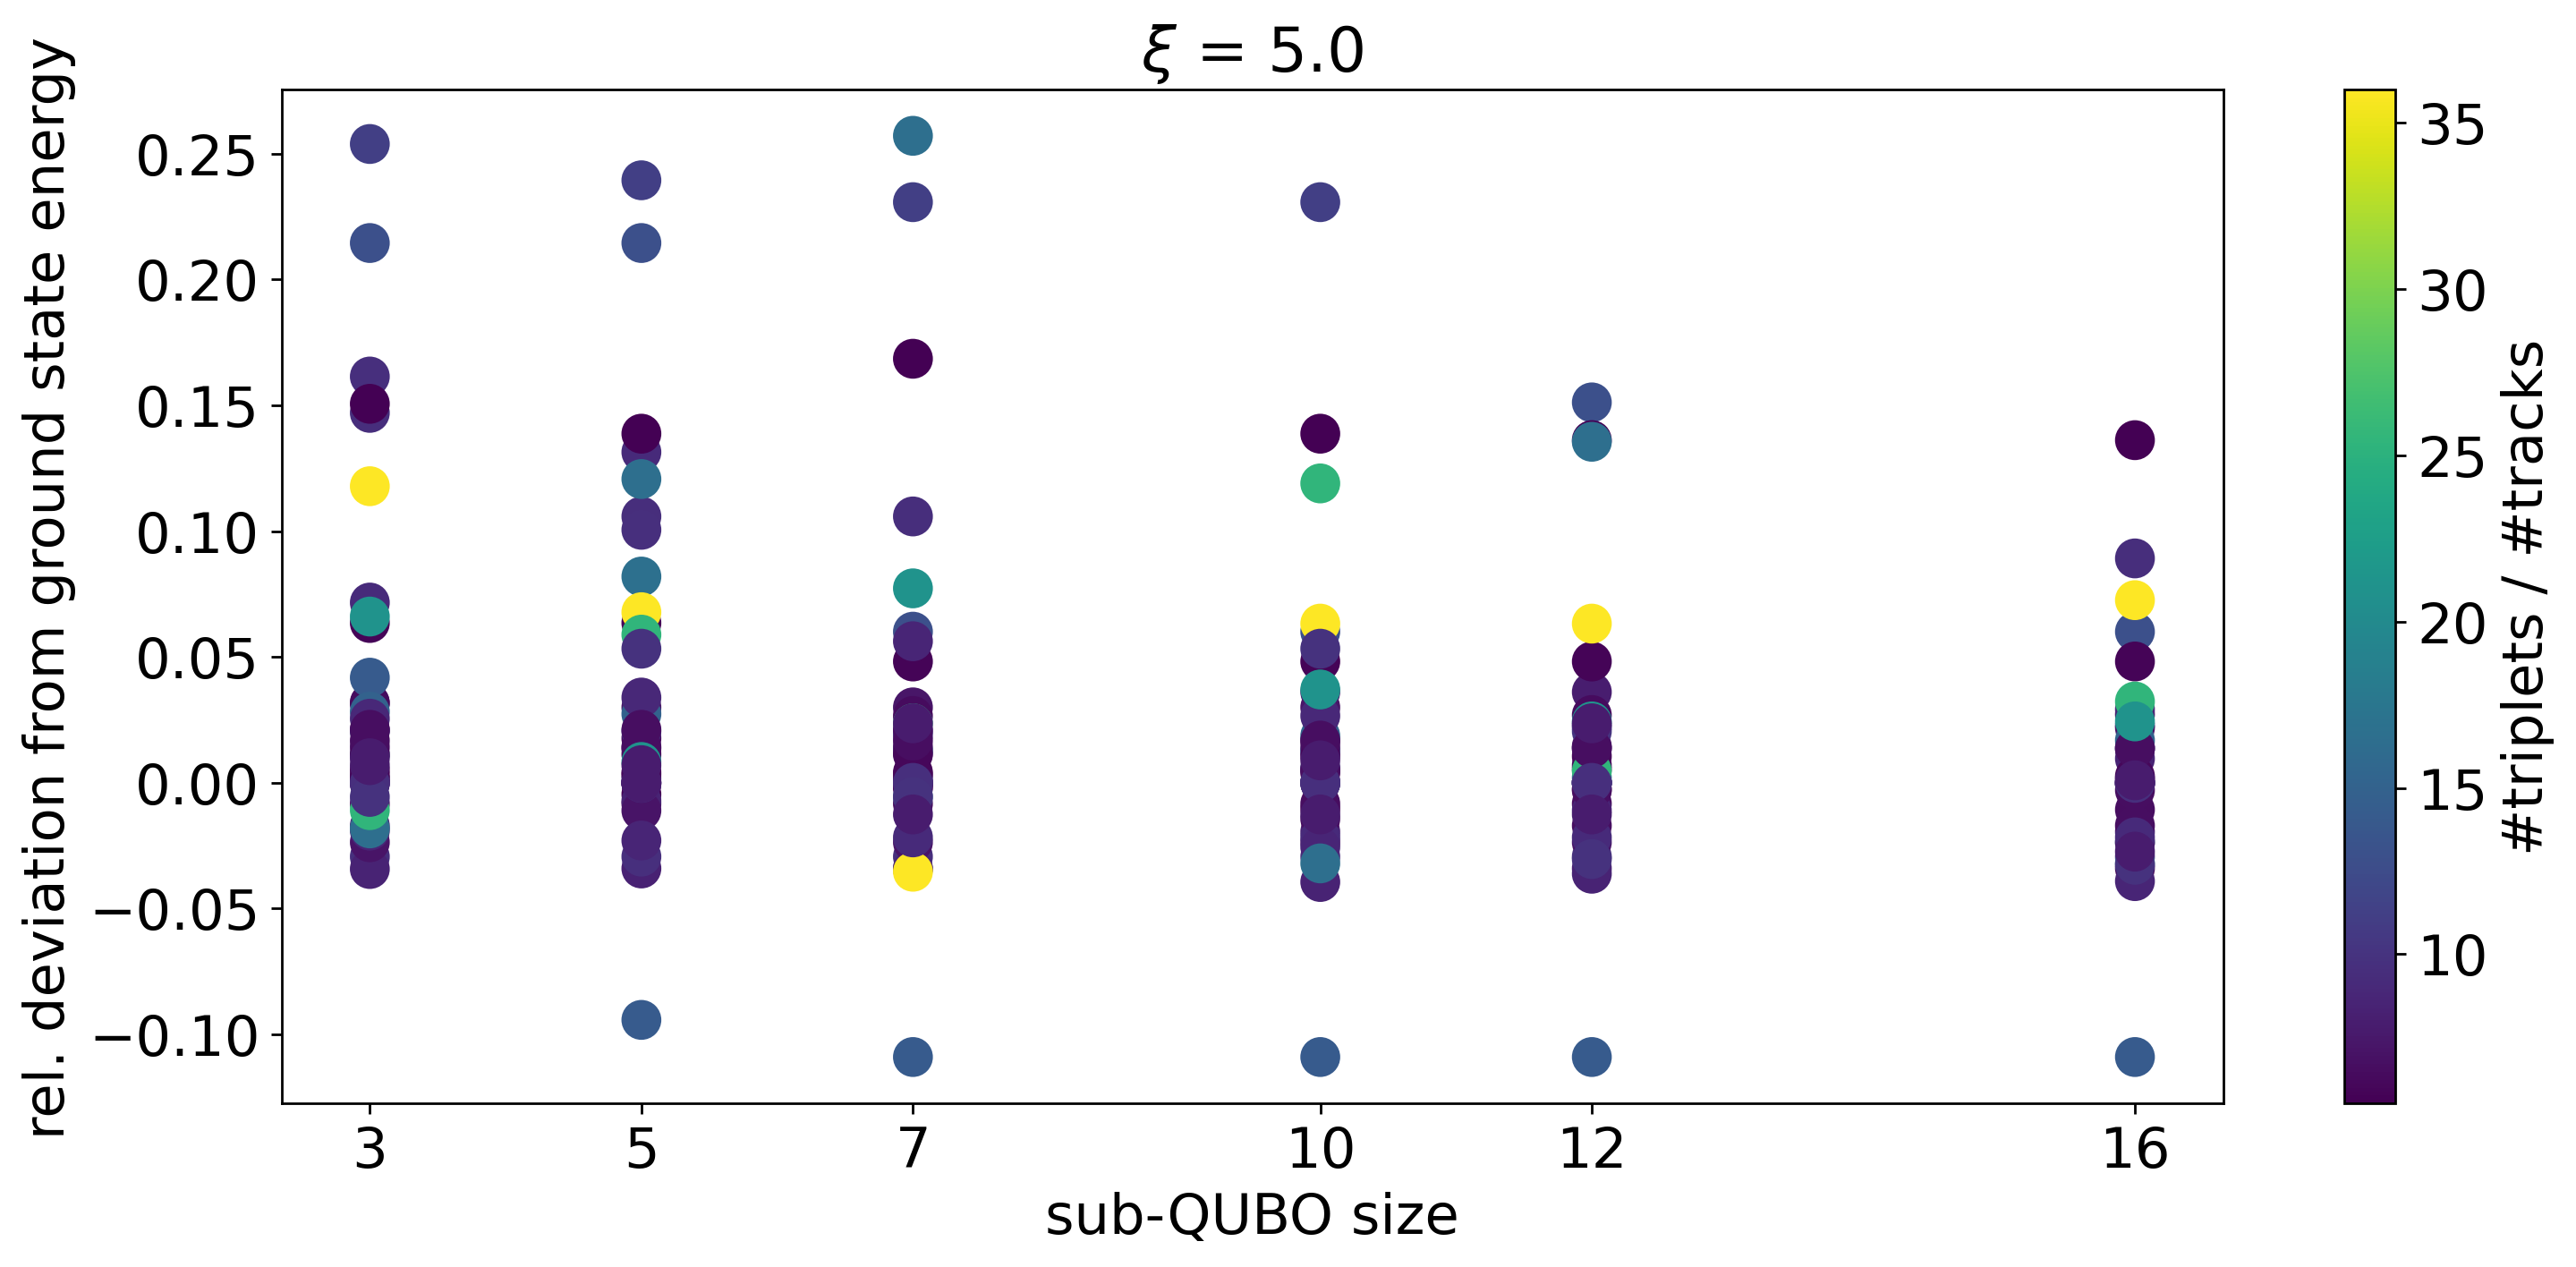

In [15]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=250)
energy_deviation = (np.array(found_energy_array) - np.array(ground_state_array)) / \
                    abs(np.array(ground_state_array))
sc = ax.scatter(subqubo_size_array, 
                energy_deviation, s=140, 
                c=np.array(problem_size_array) / np.array(track_numbers_array), 
                cmap="viridis")
ax.set_ylabel(' rel. deviation from ground state energy', fontsize=18)
ax.set_xlabel('sub-QUBO size', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_title(fr"$\xi$ = {xi}", fontsize=20)
ax.set_xticks([3, 5, 7, 10, 12, 16])
cbar = fig.colorbar(sc)
cbar.ax.tick_params(labelsize=18)
# cbar.set_clim(0, 10)
cbar.set_label("#triplets / #tracks", fontsize=18)
plt.savefig(f"xi_{xi}_density_cone.pdf")

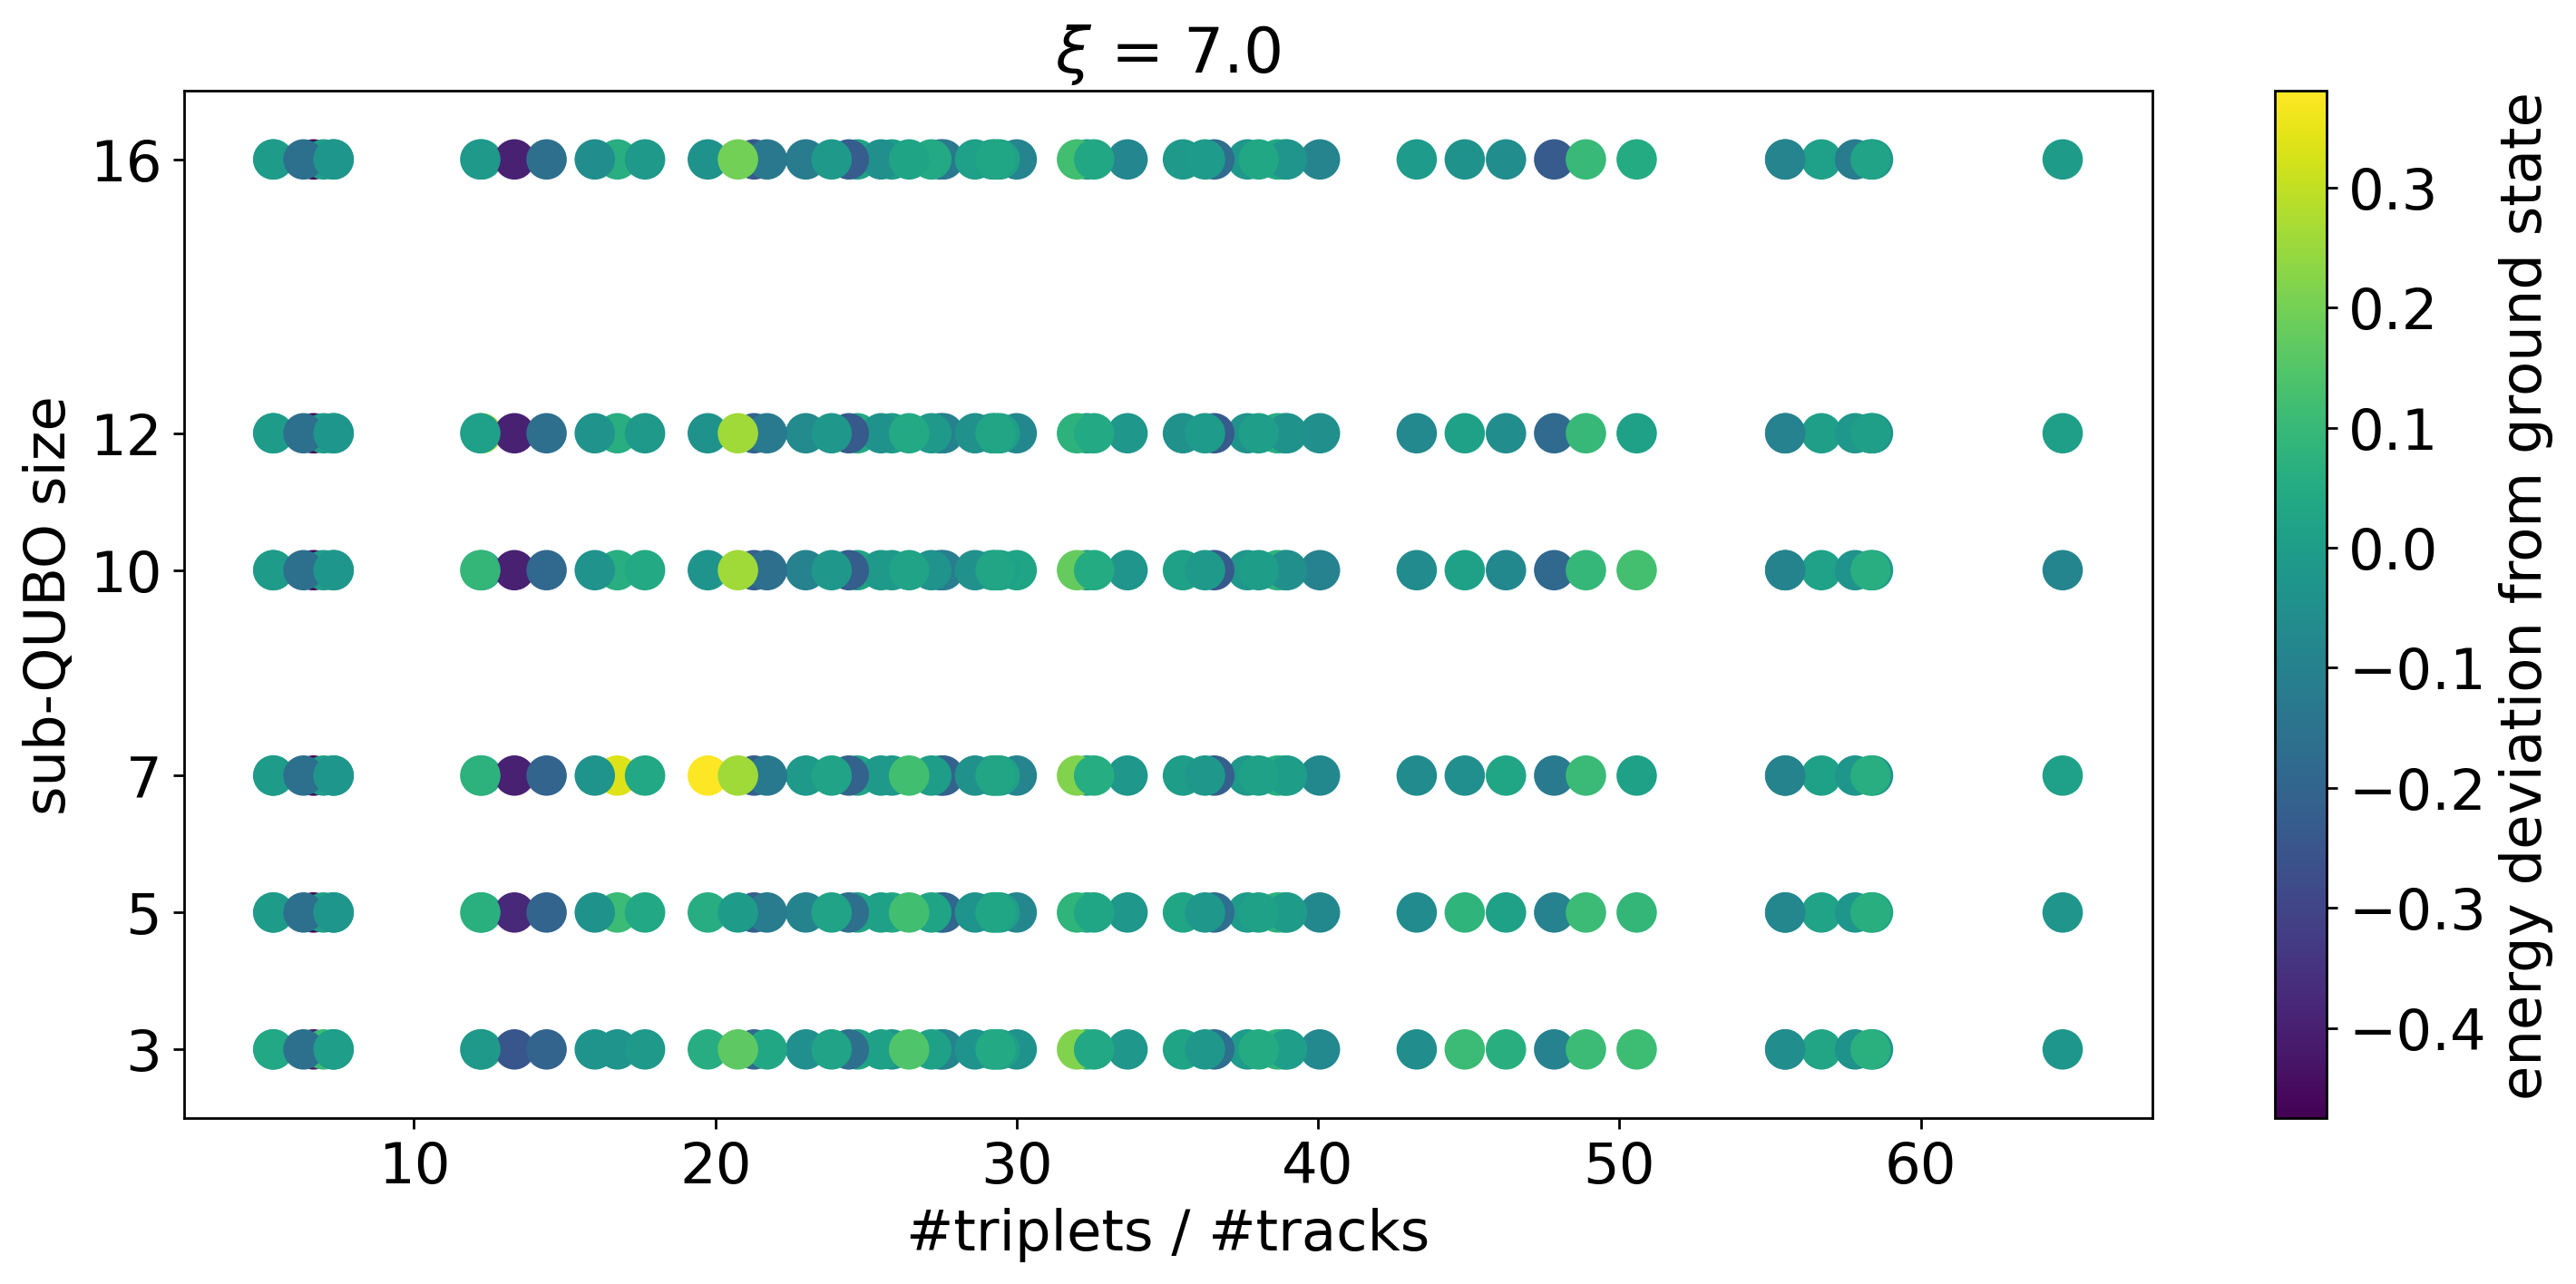

In [48]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=250)

sc = ax.scatter(np.array(problem_size_array) / np.array(track_numbers_array), 
                subqubo_size_array, s=140, 
                c=(np.array(found_energy_array) - np.array(ground_state_array)) / abs(np.array(ground_state_array)) , 
                cmap="viridis")
ax.set_ylabel('sub-QUBO size', fontsize=18)
ax.set_xlabel('#triplets / #tracks', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_title(fr"$\xi$ = {xi}", fontsize=20)
ax.set_yticks([3, 5, 7, 10, 12, 16])
plt.ylim([2, 17])
cbar = fig.colorbar(sc)
cbar.ax.tick_params(labelsize=18)
# cbar.set_clim(0, 10)
cbar.set_label(" energy deviation from ground state", fontsize=18)
plt.savefig(f"xi_{xi}_density_cone.pdf")